In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import pandas as pd
import numpy as np
import itertools
import mplfinance as mpf
import re
import math
from math import floor
import sys
import os
from dain import Adaptive_Normalizer_Layer

import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import FunctionTransformer

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, GRU, Dropout


df = pd.read_parquet('df_CNN_LSTM_1T.parquet').reset_index().reset_index().set_index('datetime', drop=True)#['2003-01-01 03:27:00':]
df_dropped = df.drop(columns=['index'])
#df.datetime = pd.to_datetime(df.datetime)
#df = df.set_index('datetime', drop=True)

In [26]:
# Define the data generator function
def data_generator(data, window_size, batch_size, indices):
    while True:
        batch_data = []
        batch_targets = []
        for index in indices:
            window_end = index
            window_start = window_end - window_size
            
            open_price = data.iloc[window_end].open_es
            
            # Extract the input sequence for the window
            input_sequence = data[window_start : window_end + 150].copy(deep=True)
            
            # Extract the target high and low values
            target_high = input_sequence[-150: ].high_es.max()
            target_low = input_sequence[-150:].low_es.min()
            
            #for col in price_cols_to_normalize:
            #    input_sequence.loc[:, col] = np.log(input_sequence[col] / open_price).replace(-np.inf, 0)

            # Add the input sequence and targets to the batch
            batch_data.append(input_sequence[:-150])
            batch_targets.append([target_high, target_low])

            #print([target_high, target_low], index)
            if len(batch_data) == batch_size:
                yield np.asarray(batch_data).astype('float32'), np.asarray(batch_targets).astype('float32')
                batch_data = []
                batch_targets = []
                
        # Yield the remaining batch if it doesn't equal the batch size
        if batch_data:
            yield np.array(batch_data).astype('float32'), np.array(batch_targets).astype('float32')

# Set the window size and batch size
window_size = 1440 #minutes in 7 days
batch_size = 8
num_features = df_dropped.shape[1]

# Set the split ratios
train_ratio = 0.8
val_ratio = 0.1

selected_features = df_dropped.columns

# set random seed for the shuffle function
np.random.seed(42)

# Get the indices for training, validation, and testing splits
indices = df.loc[(df.index.hour == 9) & (df.index.minute == 30) & (df.index.dayofweek < 5)]['index'].to_numpy()
indices = indices[indices > window_size] # Filter the indices to exclude those with insufficient historical data
np.random.shuffle(indices)
train_size = int(len(indices) * train_ratio)
val_size = int(len(indices) * val_ratio)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

#get the mean and std for normalization
price_cols_to_normalize = df_dropped.columns[(df_dropped>1).any()]
#price_cols_to_normalize = [df_dropped.columns.get_loc(c) for c in price_cols_to_normalize]
#mean = df_dropped[price_cols_to_normalize].iloc[train_indices].mean()
#std = df_dropped[price_cols_to_normalize].iloc[train_indices].std()

# Create the data generators for training, validation, and testing
train_generator = data_generator(df_dropped, window_size, batch_size, train_indices)
val_generator = data_generator(df_dropped, window_size, batch_size, val_indices)
test_generator = data_generator(df_dropped, window_size, batch_size, test_indices)

# Calculate the number of steps per epoch for training and validation
train_steps_per_epoch = len(train_indices) // batch_size
val_steps = len(val_indices) // batch_size

In [27]:
# Define the LSTM model
model = Sequential()
#model.add(Adaptive_Normalizer_Layer(input_dim=window_size))
model.add(LSTM(64, input_shape=(window_size, num_features), return_sequences=False, kernel_initializer='glorot_uniform'))
model.add(Dropout(0.5))  # Dropout regularization to reduce overfitting
# model.add(LSTM(32, return_sequences=False, kernel_initializer='glorot_uniform'))
# model.add(Dropout(0.5))  # Dropout regularization to reduce overfitting
model.add(Dense(2))  # 2 output nodes for high and low values

# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mae'], run_eagerly=True)

# Train the model using the training data generator
model.fit(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=10,
          validation_data=val_generator, validation_steps=val_steps)

os.system("printf '\a'") # or '\7'

Epoch 1/10
300/371 [=======================>......] - ETA: 16s - loss: 6560300.5000 - mae: 2308.9089

KeyboardInterrupt: 

In [97]:
train_generator = data_generator(df_dropped, window_size, batch_size, train_indices)
x,y = next(train_generator)

/Users/kush/Documents/DS/env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kush/Documents/DS/env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
price_cols_to_normalize

Index(['open_es', 'high_es', 'low_es', 'close_es', 'open_nq', 'high_nq',
       'low_nq', 'close_nq'],
      dtype='object')

In [10]:
test_generator = data_generator(df_dropped, window_size, batch_size, test_indices)
test_steps = len(test_indices) // batch_size
# Generate predictions for the test set
predictions = model.predict(test_generator, steps=test_steps)
test_generator = data_generator(df_dropped, window_size, batch_size, test_indices)
model.evaluate(test_generator, steps=test_steps)

dates = df.iloc[test_indices].index.strftime("%Y-%m-%d")[:512]

# Extract the predicted high and low values
predicted_high = predictions[:, 0]
predicted_low = predictions[:, 1]

# Reset the test data generator to get actual values
test_generator = data_generator(df_dropped, window_size, batch_size, test_indices)

# Get the actual high and low values
actual_high = []
actual_low = []
for i in range(test_steps):
    _, batch_targets = next(test_generator)
    actual_high.extend(batch_targets[:, 0])
    actual_low.extend(batch_targets[:, 1])
    
actual_high = actual_high
actual_low = actual_low

# Print the individual predictions with actual values
for i in range(len(predicted_high)):
    print(f"Sample {i+1} - {dates[i]} - Predicted/Actual High: {predicted_high[i]:.6f}, {actual_high[i]:.6f} Predicted/Actual Low: {predicted_low[i]:.6f}, {actual_low[i]:.6f}")


2/2 [==============================] - 2s 2s/step - loss: 0.0036
Sample 1 - 2021-01-14 - Predicted/Actual High: 0.001547, 0.002045 Predicted/Actual Low: -0.001473, -0.000529
Sample 2 - 2021-01-15 - Predicted/Actual High: 0.001539, 0.000732 Predicted/Actual Low: -0.001457, -0.009701
Sample 3 - 2021-01-18 - Predicted/Actual High: 0.001530, 0.001403 Predicted/Actual Low: -0.001485, -0.000401
Sample 4 - 2021-01-19 - Predicted/Actual High: 0.001562, 0.001194 Predicted/Actual Low: -0.001524, -0.003459
Sample 5 - 2021-01-20 - Predicted/Actual High: 0.001540, 0.007041 Predicted/Actual Low: -0.001447, -0.000330
Sample 6 - 2021-01-21 - Predicted/Actual High: 0.001560, 0.000196 Predicted/Actual Low: -0.001453, -0.004448
Sample 7 - 2021-01-22 - Predicted/Actual High: 0.001540, 0.004730 Predicted/Actual Low: -0.001461, -0.000395
Sample 8 - 2021-01-25 - Predicted/Actual High: 0.001511, 0.004319 Predicted/Actual Low: -0.001501, -0.005392
Sample 9 - 2021-01-26 - Predicted/Actual High: 0.001545, 0.0027

Epoch 1/50
90/90 [==============================] - 1s 7ms/step - loss: 1472.5165 - val_loss: 24.6437
Epoch 2/50
90/90 [==============================] - 1s 6ms/step - loss: 13.4137 - val_loss: 19.1790
Epoch 3/50
90/90 [==============================] - 0s 6ms/step - loss: 4.0293 - val_loss: 16.9754
Epoch 4/50
90/90 [==============================] - 1s 6ms/step - loss: 2.0420 - val_loss: 16.5402
Epoch 5/50
90/90 [==============================] - 0s 6ms/step - loss: 1.2957 - val_loss: 16.1952
Epoch 6/50
90/90 [==============================] - 0s 5ms/step - loss: 0.9084 - val_loss: 16.5584
Epoch 7/50
90/90 [==============================] - 0s 6ms/step - loss: 0.7091 - val_loss: 16.6134
Epoch 8/50
90/90 [==============================] - 1s 6ms/step - loss: 0.5830 - val_loss: 16.7589
Epoch 9/50
90/90 [==============================] - 0s 6ms/step - loss: 0.5079 - val_loss: 16.7583
Epoch 10/50
90/90 [==============================] - 0s 6ms/step - loss: 0.4535 - val_loss: 17.1200
Epoch

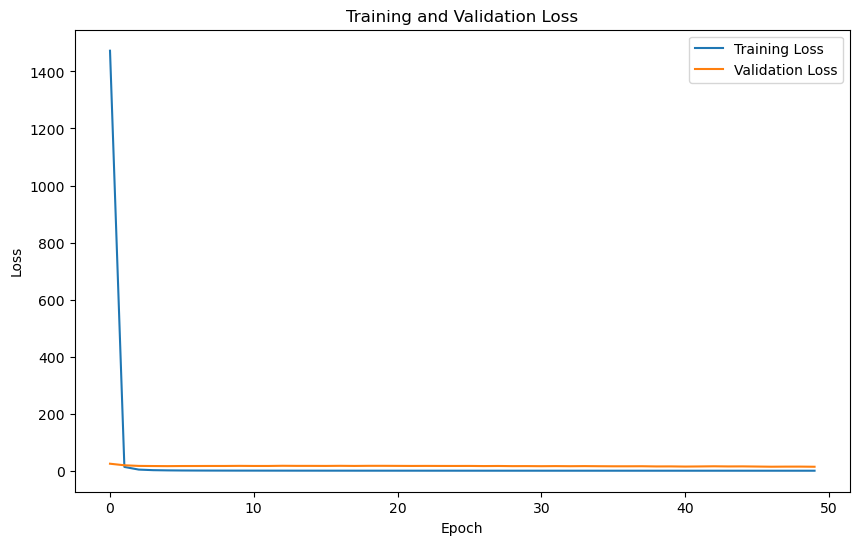

In [16]:
# Split data into features and target
target_cols = ['Morning_High', 'Morning_Low', 'Daily_High', 'Daily_Low']

X = df_final.drop(columns=target_cols)
y = df_final[target_cols]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Create a pipeline for preprocessing and modeling
price_cols = [
    col for col in X.columns 
    if any(sub in col for sub in ['open', 'high', 'low', 'close', 'swing_', '_low', '_high']) 
    and not any(sub in col for sub in ['next'])
]

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler()),
        #('num', FunctionTransformer(LogTransformer().transform), price_cols)
    ])

pipeline = Pipeline([
    #('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))  # Impute any missing values after log transformation
])

# Preprocess the data
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

# Define the MLP model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4)  # Two output neurons for 'Daily_High' and 'Daily_Low'
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Fit the model to the training data and use the custom callback
history = model.fit(X_train_preprocessed, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on test data
y_pred = model.predict(X_test_preprocessed)

r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')
mae_scores = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
mse_scores = mean_squared_error(y_test, y_pred, multioutput='raw_values')
rmse_scores = np.sqrt(mse_scores)

for i, (target, r2, mae, mse, rmse) in enumerate(zip(target_cols, r2_scores, mae_scores, mse_scores, rmse_scores)):
    print(f'{target} metrics:')
    print(f'R^2 score: {r2:.6f}')
    print(f'MAE: {mae:.6f}')
    print(f'MSE: {mse:.6f}')
    print(f'RMSE: {rmse:.6f}\n')
    
os.system("printf '\a'") # or '\7'

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [14]:
import pandas as pd

def get_most_accurate_predictions_combined_error(y_test, datetime_indexes, y_pred, target_names, N=10):
    # Calculate absolute errors for each target
    absolute_errors_target_1 = mean_absolute_error(y_test.iloc[:, 0], y_pred[:, 0])
    absolute_errors_target_2 = mean_absolute_error(y_test.iloc[:, 1], y_pred[:, 1])
    absolute_errors_target_3 = mean_absolute_error(y_test.iloc[:, 2], y_pred[:, 2])
    absolute_errors_target_4 = mean_absolute_error(y_test.iloc[:, 3], y_pred[:, 3])
    
    # Calculate combined absolute error
    combined_absolute_error_morning = -np.mean([absolute_errors_target_1, absolute_errors_target_2])
    combined_absolute_error_daily = -np.mean([absolute_errors_target_3, absolute_errors_target_4])

    # Create a DataFrame with datetime index, actual values, predicted values, and combined absolute error
    accuracy_df = pd.DataFrame({
        'datetime': datetime_indexes,
        'year': X_test.year,
        f'a_{target_names[0]}': y_test.iloc[:, 0],
        f'p_{target_names[0]}': y_pred[:, 0],
        f'a_{target_names[1]}': y_test.iloc[:, 1],
        f'p_{target_names[1]}': y_pred[:, 1],
        f'a_{target_names[2]}': y_test.iloc[:, 2],
        f'p_{target_names[2]}': y_pred[:, 2],
        f'a_{target_names[3]}': y_test.iloc[:, 3],
        f'p_{target_names[3]}': y_pred[:, 3],
        'combined_error_morning': combined_absolute_error_morning,
        'combined_error_daily': combined_absolute_error_daily
    })
    
    accuracy_df = accuracy_df.join(df_final[['month', 'day', 'open_es']])
    accuracy_df['a_Daily_High'] = round(np.exp(accuracy_df['a_Daily_High']) * accuracy_df.open_es,2)
    accuracy_df['a_Daily_Low'] = round(np.exp(accuracy_df['a_Daily_Low']) * accuracy_df.open_es,2)
    accuracy_df['p_Daily_High'] = round(np.exp(accuracy_df['p_Daily_High']) * accuracy_df.open_es,2)
    accuracy_df['p_Daily_Low'] = round(np.exp(accuracy_df['p_Daily_Low']) * accuracy_df.open_es,2)
    accuracy_df['a_Morning_High'] = round(np.exp(accuracy_df['a_Morning_High']) * accuracy_df.open_es,2)
    accuracy_df['a_Morning_Low'] = round(np.exp(accuracy_df['a_Morning_Low']) * accuracy_df.open_es,2)
    accuracy_df['p_Morning_High'] = round(np.exp(accuracy_df['p_Morning_High']) * accuracy_df.open_es,2)
    accuracy_df['p_Morning_Low'] = round(np.exp(accuracy_df['p_Morning_Low']) * accuracy_df.open_es,2)
    accuracy_df['combined_error_morning'] = combined_absolute_error_morning
    accuracy_df['combined_error_daily'] = combined_absolute_error_daily
    
    return accuracy_df

# Example usage
target_names = target_cols

# Get the most accurate predictions based on the combined error (assuming y_test and y_pred are defined)
most_accurate_df = get_most_accurate_predictions_combined_error(y_test, y_test.index, y_pred, target_names, N=10)

# Display the results
print("Most accurate predictions based on combined error:")
#most_accurate_df.head(10)
most_accurate_df.sort_values(by=['combined_error_morning', 'year', 'month', 'day'], ascending=False).head(10)

Most accurate predictions based on combined error:


,datetime,year,a_Morning_High,p_Morning_High,a_Morning_Low,p_Morning_Low,a_Daily_High,p_Daily_High,a_Daily_Low,p_Daily_Low,combined_error_morning,combined_error_daily,month,day,open_es
4500,4500,2023,4188.25,4174.59,4149.50,4156.79,4188.25,4176.18,4137.26,4156.56,-0.003413,-0.005288,4,14,4165.50
4499,4499,2023,4148.75,4139.27,4124.50,4121.61,4177.00,4140.84,4124.50,4121.38,-0.003413,-0.005288,4,13,4130.25
4498,4498,2023,4160.00,4166.07,4120.01,4148.31,4160.00,4167.66,4112.51,4148.08,-0.003413,-0.005288,4,12,4157.00
4497,4497,2023,4142.00,4150.79,4128.00,4133.09,4151.00,4152.37,4128.00,4132.86,-0.003413,-0.005288,4,11,4141.75
4496,4496,2023,4116.50,4113.71,4097.75,4096.17,4136.49,4115.28,4097.75,4095.94,-0.003413,-0.005288,4,10,4104.75
4495,4495,2023,4122.00,4116.97,4097.00,4099.41,4135.75,4118.54,4097.00,4099.18,-0.003413,-0.005288,4,6,4108.00
4494,4494,2023,4128.25,4129.49,4102.25,4111.88,4128.25,4131.07,4099.50,4111.65,-0.003413,-0.005288,4,5,4120.50
4493,4493,2023,4164.25,4170.08,4126.24,4152.30,4164.25,4171.67,4116.24,4152.07,-0.003413,-0.005288,4,4,4161.00
4492,4492,2023,4157.75,4141.52,4127.75,4123.86,4157.75,4143.10,4127.75,4123.63,-0.003413,-0.005288,4,3,4132.50
4491,4491,2023,4117.01,4100.18,4089.50,4082.69,4142.26,4101.74,4089.50,4082.47,-0.003413,-0.005288,3,31,4091.25
